In [77]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd

import math
import community as community_louvain
import urllib.request
import gzip
import obonet
import colorsys
# from colormap import rgb2hex
# from colormap import hex2rgb
import pickle as pk
# from prettytable import PrettyTable
import os.path
import pandas as pd
from collections import defaultdict, Counter, ChainMap
import umap
import scipy.sparse as sp
from scipy.spatial import KDTree
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
import time
# import statsmodels.sandbox.stats.multicomp as mc
from sklearn.preprocessing import normalize

import plotly.graph_objects as gp
from plotly.offline import init_notebook_mode, iplot
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# %matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

In [92]:
def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    info.append(f"Density: {round(100. * nx.density(G), 3)} %")

    if nx.is_weighted(G):
        info.append(f"Weighted: Yes")
        
        # Calculate the average degree considering edge weights for weighted graphs
        avg_weighted_degree = sum(weight for u, v, weight in G.edges(data=True)) / G.number_of_nodes()
        info.append(f"Average Weighted Degree: {round(avg_weighted_degree, 2)}")
    else:
        info.append(f"Weighted: No")
        
        # Calculate the average degree as usual for unweighted graphs
        avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
        info.append(f"Average Degree: {round(avg_degree, 2)}")

    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")

    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    
    return "\n".join(info)

### random geometric graph

place n nodes randomly on a circle 

link them according to distance on that circle

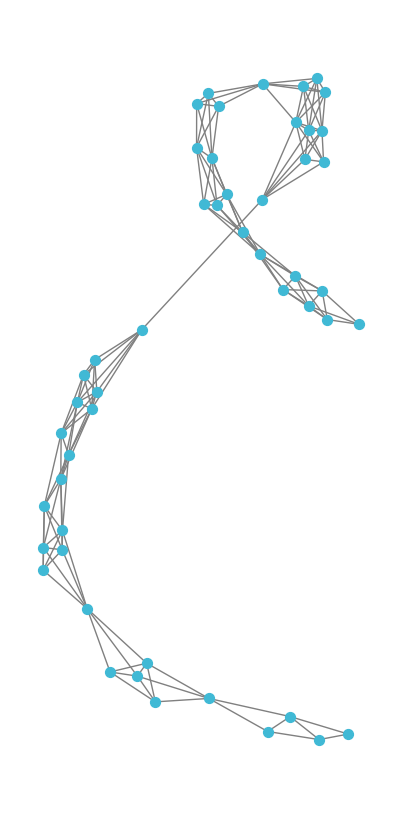

In [29]:


def create_circular_graph(n, mu):
    # Create a new graph
    G = nx.Graph()

    # Place n nodes on a circle
    theta = np.random.uniform(0, 2 * np.pi, n)
    positions = {i: (np.cos(t), np.sin(t)) for i, t in enumerate(theta)}
    
    # Add nodes to the graph with their positions
    for i in range(n):
        G.add_node(i, pos=positions[i])

    # Connect nodes if their distance along the circle is less than mu
    for i in range(n):
        for j in range(i + 1, n):
            distance = min(abs(theta[i] - theta[j]), 2 * np.pi - abs(theta[i] - theta[j]))
            if distance < mu:
                G.add_edge(i, j)

    return G, positions

# Parameters
n = 50  # Number of nodes
mu = .4  # Threshold value for connecting nodes

# Create the circular graph
G, positions = create_circular_graph(n, mu)

positions = nx.spring_layout(G)
# Draw the graph
plt.figure(figsize=(8, 8))

nx.draw(G, positions, with_labels=False, node_size=50, node_color='#40b9d5', edge_color='gray')
plt.gca().set_aspect('equal')
plt.show()


In [33]:
dict(G.degree()).values()

dict_values([2, 7, 6, 7, 5, 6, 6, 4, 8, 6, 8, 8, 7, 3, 7, 6, 6, 7, 3, 4, 7, 5, 7, 5, 8, 7, 6, 3, 5, 8, 6, 6, 5, 5, 6, 6, 5, 6, 6, 9, 4, 7, 5, 5, 8, 6, 5, 8, 5, 6])

In [34]:
np.mean(list(dict(G.degree()).values()))

5.92

In [20]:
S = 1000
n = 10
l_mu = np.arange(.2,1.8,.1)
avg_numcomps = []

for mu in l_mu:
    l_num_comps = []
    for _ in range(S):
        G, positions = create_circular_graph(n, mu)

        l_num_comps.append(nx.number_connected_components(G))
    avg_numcomps.append(np.mean(l_num_comps))



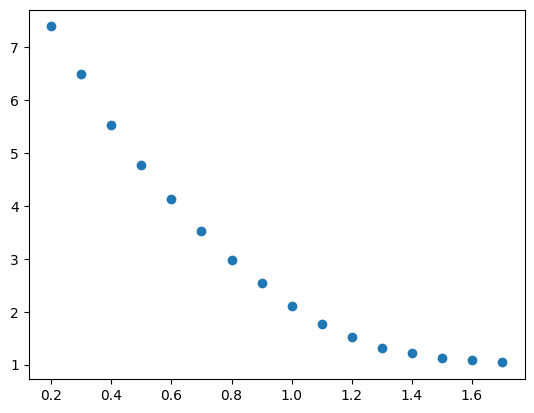

In [21]:
plt.scatter(l_mu,avg_numcomps)

### generate spatial network in d-dimensions 

connection probability:

$p_{ij} = fx_{ij}^{-\beta}$

where $x_{ij}$ denotes the Euclidean distance between nodes

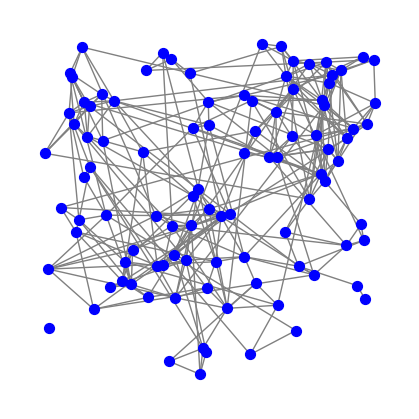

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt



def generate_network(list_nodes, beta, p_factor):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(list_nodes)

    num_nodes = len(list_nodes)
    # Add edges based on the connection probability
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            # Calculate Euclidean distance between nodes
            distance = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))
            # Calculate connection probability
            probability = p_factor*distance ** -beta
            # Add edge with the calculated probability
            if np.random.rand() < probability:
                G.add_edge(i, j)
    return G

# Parameters
num_nodes = 100  # Number of nodes
beta = 2         # Exponent for the connection probability
dim = 2          # Dimensionality (2D)

# Generate random positions for the nodes in 2D
positions = {i: np.random.rand(dim) for i in range(num_nodes)}

p_factor = .005

G = generate_network(positions.keys(), beta, p_factor)

# Draw the graph
plt.figure(figsize=(4, 4))
nx.draw(G, pos=positions, with_labels=False, node_size=50, node_color="blue", edge_color="gray")
plt.show()


Text(0.5, 0, 'connectivity amplitude')

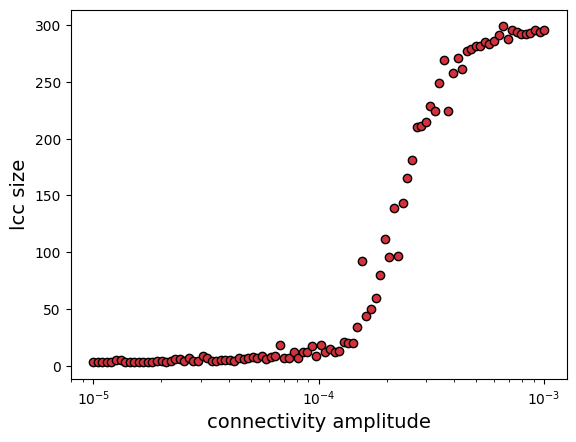

In [26]:
# Parameters
num_nodes = 300  # Number of nodes
beta = 2         # Exponent for the connection probability
dim = 2          # Dimensionality (2D)

# Generate random positions for the nodes in 2D
positions = {i: np.random.rand(dim) for i in range(num_nodes)}

l_factor = np.logspace(-5,-3,num = 100)
l_lcc = []
for p_factor in l_factor:
    G = generate_network(positions.keys(), beta, p_factor)
    lcc_size =  len(max(nx.connected_components(G), key=len))
    l_lcc.append(lcc_size)

plt.scatter(l_factor,l_lcc, edgecolors='k',c='#d2323c')
plt.xscale('log')
plt.ylabel('lcc size', fontsize = 14)
plt.xlabel('connectivity amplitude', fontsize = 14)

## $\epsilon$ - networks

distribute randomly N nodes in space 

(choose uniform distribution and Euclidean flat space, can be changed however)

Define distances according to a metric - typically $l^2$ norm. 

Link nodes together via a connection probablity function that goes up for decreasing distances. 

In case of a box function the connections are deterministic and just given by the pairwise distances


Graph Name: 
Graph Type: Graph
Number of Nodes: 500
Number of Edges: 1768
Density: 1.417 %
Weighted: No
Average Degree: 7.07
Connected: No
Number of Connected Components: 2
Directed: No


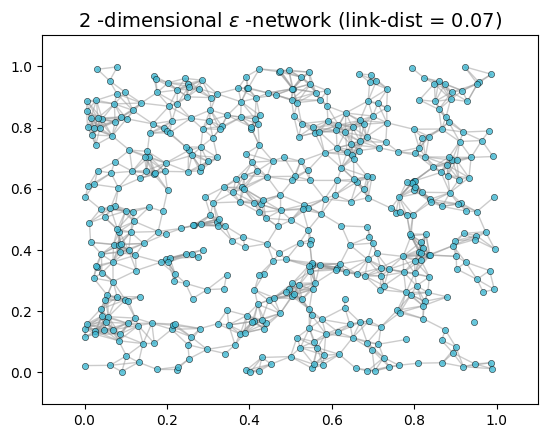

In [104]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt



def generate_spatial_network(N, min_distance,dim):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(N))

    positions = {i: np.random.rand(dim) for i in range(N)}

    # Add edges based on the connection probability
    for i in range(num_nodes):
        for j in range(i + 1, N):
            # Calculate Euclidean distance between nodes (box function)
            distance = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))

            if distance < min_distance:
                G.add_edge(i, j)
    return G, positions

# spatial 

# Parameters
num_nodes = 500  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .07

G, positions = generate_spatial_network(num_nodes, min_d,dim)

print(Ginfo(G))

fig, ax = plt.subplots()
# plt.figure(figsize=(5,3))
nx.draw_networkx_edges(G,positions,edge_color='#999999',alpha = .5)
nx.draw_networkx_nodes(G,pos = positions , 
                       nodelist=sorted(G.nodes()),
                       node_color='#40b9d4',
                       node_size=20,
                       edgecolors='k',
                       linewidths=.4,
                       alpha = .8, 
                       ax=ax)
ax.set_title('%s -dimensional $\epsilon$ -network (link-dist = %s)' %(dim,min_d), fontsize = 14)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### spring layout

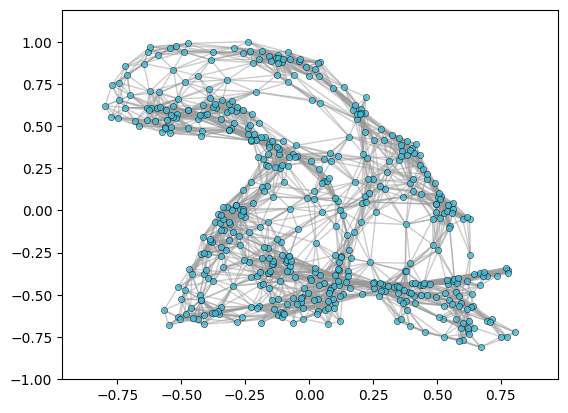

In [89]:
pos_spring = nx.spring_layout(G)

fig, ax = plt.subplots()
# plt.figure(figsize=(5,3))
nx.draw_networkx_edges(G,pos_spring,edge_color='#999999',alpha = .5)
nx.draw_networkx_nodes(G,pos = pos_spring , 
                       nodelist=sorted(G.nodes()),
                       node_color='#40b9d4',
                       node_size=20,
                       edgecolors='k',
                       linewidths=.4,
                       alpha = .8, 
                       ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

### percolation behavior

when does a giant component form
 



Text(0.5, 0, 'link_dist')

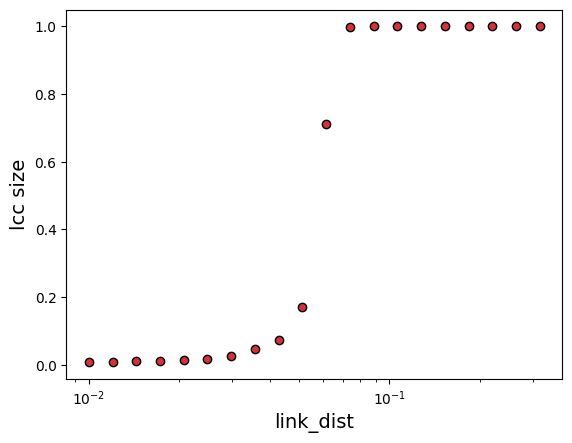

In [111]:
num_nodes = 400
l_factor = np.logspace(-2,-.5,num = 20)
l_lcc = []
for min_d in l_factor:
    G, positions = generate_spatial_network(num_nodes, min_d,dim)
    lcc_size =  len(max(nx.connected_components(G), key=len))
    l_lcc.append(lcc_size/num_nodes)

plt.scatter(l_factor,l_lcc, edgecolors='k',c='#d2323c')
plt.xscale('log')
plt.ylabel('lcc size', fontsize = 14)
plt.xlabel('link_dist', fontsize = 14)

In [115]:
l_factor = np.logspace(-2,-.2,num = 100)
crit_min_d = []
for num_nodes in range(100,1000,100):

    for min_d in l_factor:
        G, positions = generate_spatial_network(num_nodes, min_d,dim)
        lcc_size =  len(max(nx.connected_components(G), key=len))
        if lcc_size/num_nodes > .9:
            crit_min_d.append(min_d)
            break



Text(0.5, 0, 'number of nodes')

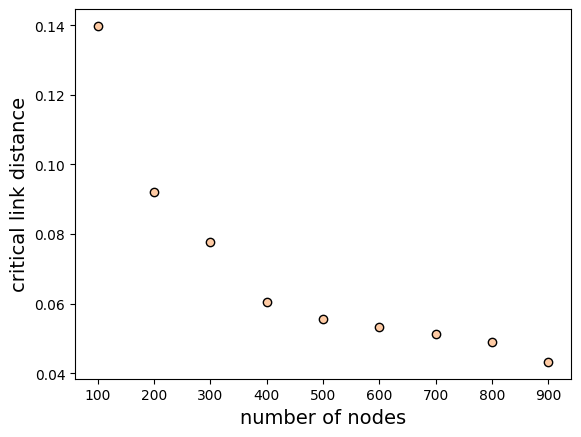

In [119]:
plt.scatter(range(100,1000,100),crit_min_d, edgecolors='k',c='#ffcba4')
# plt.xscale('log')
plt.ylabel('critical link distance', fontsize = 14)
plt.xlabel('number of nodes', fontsize = 14)

### Scaling behavior


How does the 

* number of edges

* avg degree

* density 

change with the number of nodes

In [124]:
# num_nodes = 500  # Number of nodes
dim = 2        # Dimensionality (2D)
min_d = .1

nodes_range = range(50,1000,50)
l_edges = []
l_avgk = []
l_density = []
for n in nodes_range:
    G, positions = generate_spatial_network(n, min_d,dim)
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    rho = nx.density(G)
    l_edges.append(G.number_of_edges())
    l_avgk.append(avg_degree)
    l_density.append(rho)





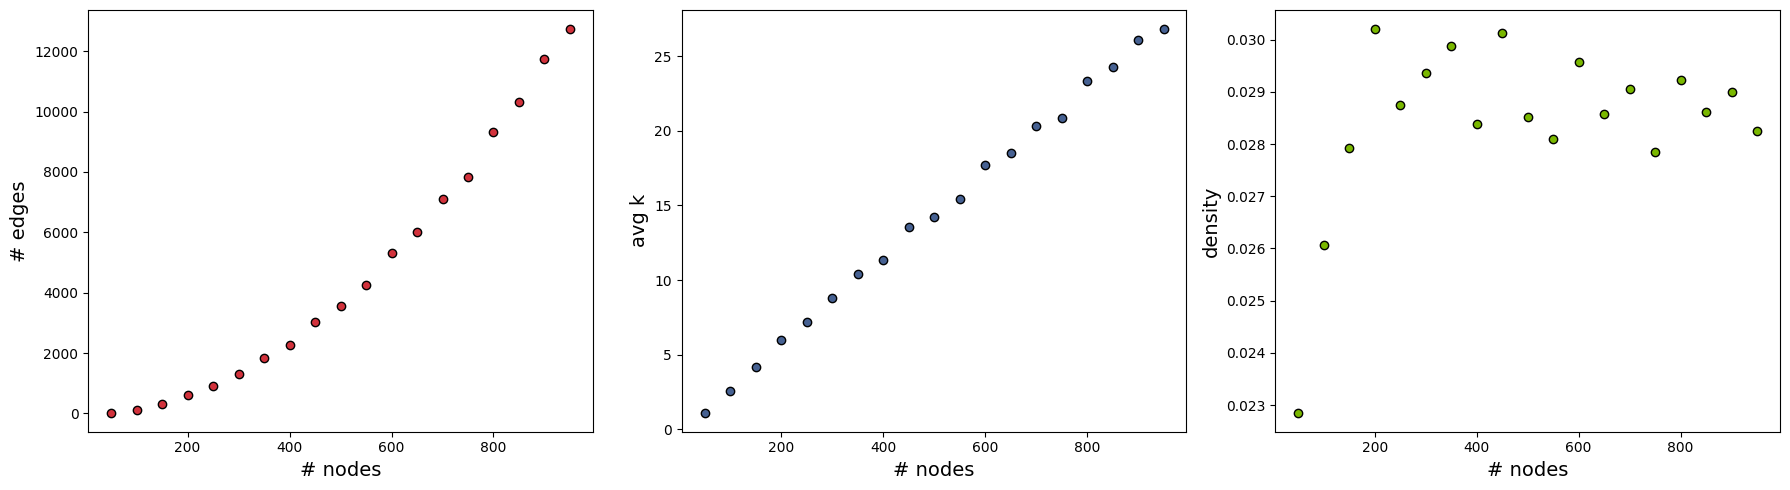

In [125]:
# Create a figure and three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# First subplot
axes[0].scatter(nodes_range, l_edges, edgecolors='k', c='#d2323c')
axes[0].set_ylabel('# edges', fontsize=14)
axes[0].set_xlabel('# nodes', fontsize=14)

# Second subplot
axes[1].scatter(nodes_range, l_avgk, edgecolors='k', c='#466192')
axes[1].set_ylabel('avg k', fontsize=14)
axes[1].set_xlabel('# nodes', fontsize=14)

# Third subplot
axes[2].scatter(nodes_range, l_density, edgecolors='k', c='#7ab800')
axes[2].set_ylabel('density', fontsize=14)
axes[2].set_xlabel('# nodes', fontsize=14)

# Adjust layout
plt.tight_layout()

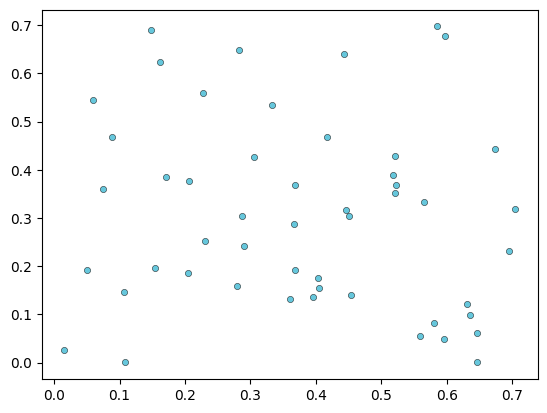

In [38]:

def generate_spatial_network_scaled(N, min_distance,dim):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(N))

    scaling_factor = np.power(N, 1/dim) * min_distance

    positions = {i: np.random.rand(dim) * scaling_factor for i in range(N)}

    # Add edges based on the connection probability
    for i in range(num_nodes):
        for j in range(i + 1, N):
            # Calculate Euclidean distance between nodes
            distance = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))

            if distance < min_distance:
                G.add_edge(i, j)
    return G, positions


# Parameters
num_nodes = 50  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1

G, positions = generate_spatial_network_scaled(num_nodes, min_d,dim)

fig, ax = plt.subplots()
# plt.figure(figsize=(5,3))
# nx.draw_networkx_edges(G,positions,edge_color='#999999',alpha = .5)
nx.draw_networkx_nodes(G,pos = positions , 
                       nodelist=sorted(G.nodes()),
                       node_color='#40b9d4',
                       node_size=20,
                       edgecolors='k',
                       linewidths=.4,
                       alpha = .8, 
                       ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

### pairwise distances no scaling versus with scaling

In [40]:
from scipy.spatial.distance import pdist, squareform


# Convert positions dictionary to a numpy array
positions_array = np.array(list(positions.values()))

# Calculate all pairwise distances
pairwise_distances = pdist(positions_array)

# Convert the distances to a square matrix form
# pairwise_distances_matrix = squareform(pairwise_distances)


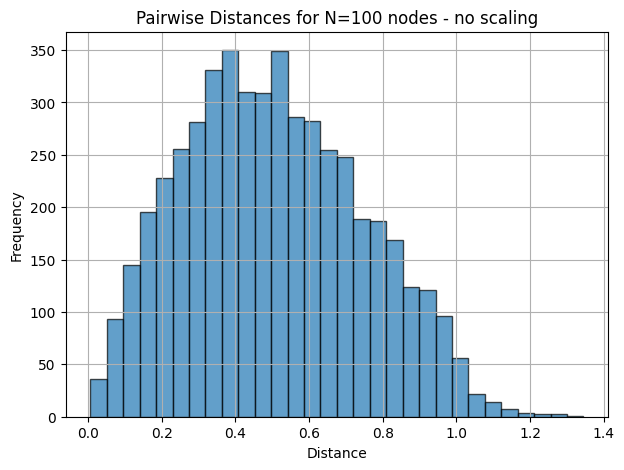

In [47]:


# Parameters
num_nodes = 100  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1

G, positions = generate_spatial_network(num_nodes, min_d,dim)

positions_array = np.array(list(positions.values()))
# Calculate all pairwise distances
pairwise_distances = pdist(positions_array)

# Create a histogram of the pairwise distances
plt.figure(figsize=(7, 5))
plt.hist(pairwise_distances, bins=30, edgecolor='k', alpha=0.7)
plt.title('Pairwise Distances for N=%s nodes - no scaling' %num_nodes)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)


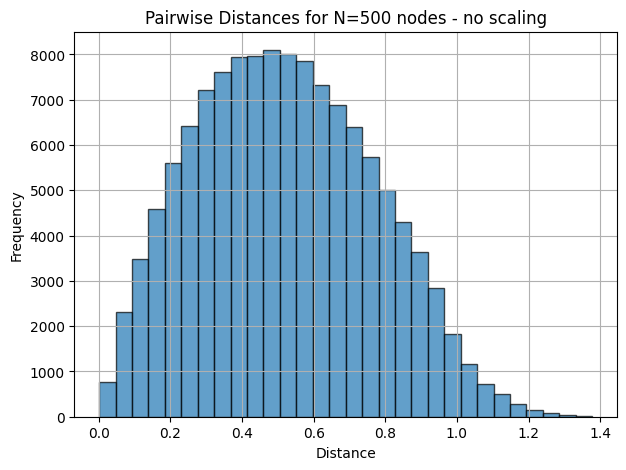

In [48]:


# Parameters
num_nodes = 500  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1

G, positions = generate_spatial_network(num_nodes, min_d,dim)

positions_array = np.array(list(positions.values()))
# Calculate all pairwise distances
pairwise_distances = pdist(positions_array)

# Create a histogram of the pairwise distances
plt.figure(figsize=(7, 5))
plt.hist(pairwise_distances, bins=30, edgecolor='k', alpha=0.7)
plt.title('Pairwise Distances for N=%s nodes - no scaling' %num_nodes)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)


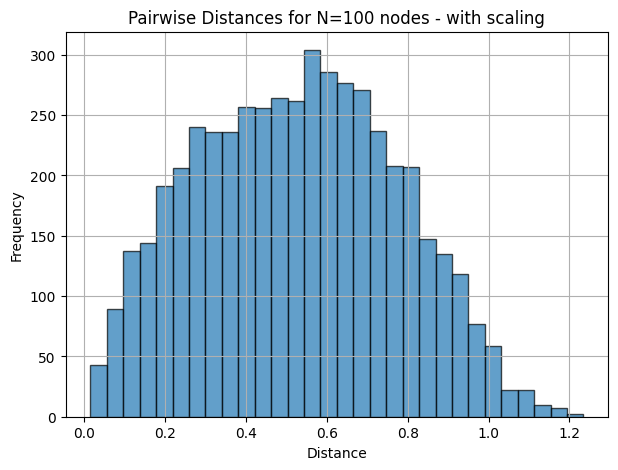

In [49]:


# Parameters
num_nodes = 100  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1

G, positions = generate_spatial_network_scaled(num_nodes, min_d,dim)

positions_array = np.array(list(positions.values()))
# Calculate all pairwise distances
pairwise_distances = pdist(positions_array)

# Create a histogram of the pairwise distances
plt.figure(figsize=(7, 5))
plt.hist(pairwise_distances, bins=30, edgecolor='k', alpha=0.7)
plt.title('Pairwise Distances for N=%s nodes - with scaling' %num_nodes)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)


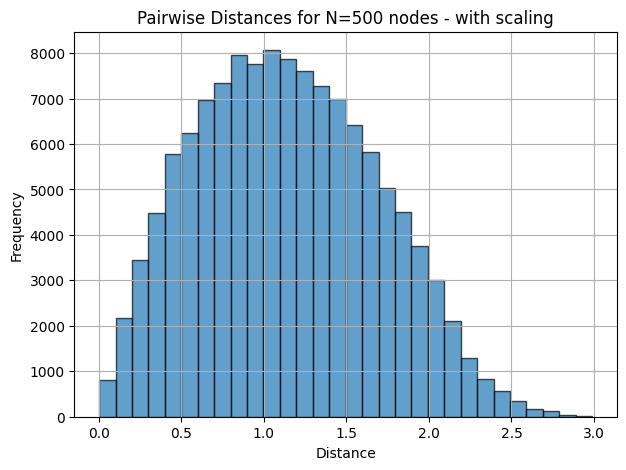

In [50]:


# Parameters
num_nodes = 500  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1

G, positions = generate_spatial_network_scaled(num_nodes, min_d,dim)

positions_array = np.array(list(positions.values()))
# Calculate all pairwise distances
pairwise_distances = pdist(positions_array)

# Create a histogram of the pairwise distances
plt.figure(figsize=(7, 5))
plt.hist(pairwise_distances, bins=30, edgecolor='k', alpha=0.7)
plt.title('Pairwise Distances for N=%s nodes - with scaling' %num_nodes)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)


### density

In [72]:


def count_nodes_in_box(positions, box_side_length, array_length, dim):
    """
    Count the number of nodes within a randomly placed box of given side length.
    
    Parameters:
    - positions: Dictionary with node positions (values should be numpy arrays).
    - box_side_length: Length of the side of the smaller box.
    - array_length: Length of the original array in which the nodes are positioned.
    - dim: Dimension of the box (e.g., 2 for 2D, 3 for 3D).
    
    Returns:
    - Number of nodes within the box.
    """
    # Calculate the scaling factor based on the array length
    scaling_factor = np.power(array_length, 1/dim)

    # Randomly place the sampling box within the larger space, ensuring it does not cross the borders
    box_origin = np.random.rand(dim) * (scaling_factor - box_side_length)

    # Count the number of nodes within the box
    count = 0
    for pos in positions.values():
        if all(box_origin[i] <= pos[i] < box_origin[i] + box_side_length for i in range(dim)):
            count += 1
    return count




# Parameters
num_nodes = 100  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1
box_side_length = 0.5  # Adjust this value as needed


G, positions = generate_spatial_network(num_nodes, min_d,dim)

S = 1000
# Count the number of nodes within the box
avg_number_in_box = 0
for s in range(S):
    num_nodes_in_box = count_nodes_in_box(positions, box_side_length, array_length=1, dim=dim)
    avg_number_in_box += num_nodes_in_box

print(f'Number of nodes in the box: {avg_number_in_box/S}')



# Parameters
num_nodes = 500  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1
box_side_length = 0.5  # Adjust this value as needed


G, positions = generate_spatial_network(num_nodes, min_d,dim)

S = 1000
# Count the number of nodes within the box
avg_number_in_box = 0
for s in range(S):
    num_nodes_in_box = count_nodes_in_box(positions, box_side_length, array_length=1, dim=dim)
    avg_number_in_box += num_nodes_in_box

print(f'Number of nodes in the box: {avg_number_in_box/S}')


Number of nodes in the box: 23.634
Number of nodes in the box: 121.749


scaled:

In [74]:
# Parameters
num_nodes = 100  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1
box_side_length = 0.5  # Adjust this value as needed


G, positions = generate_spatial_network_scaled(num_nodes, min_d,dim)

S = 1000
# Count the number of nodes within the box
avg_number_in_box = 0
for s in range(S):
    num_nodes_in_box = count_nodes_in_box(positions, box_side_length, array_length=1, dim=dim)
    avg_number_in_box += num_nodes_in_box

print(f'Number of nodes in the box: {avg_number_in_box/S}')



# Parameters
num_nodes = 1000  # Number of nodes
dim = 2          # Dimensionality (2D)
min_d = .1
box_side_length = 0.5  # Adjust this value as needed


G, positions = generate_spatial_network_scaled(num_nodes, min_d,dim)

S = 1000
# Count the number of nodes within the box
avg_number_in_box = 0
for s in range(S):
    num_nodes_in_box = count_nodes_in_box(positions, box_side_length, array_length=1, dim=dim)
    avg_number_in_box += num_nodes_in_box

print(f'Number of nodes in the box: {avg_number_in_box/S}')

Number of nodes in the box: 27.758
Number of nodes in the box: 25.761


### spatial network model 

with two parameters $N$ as the number of nodes

and a minimal distance $d$ defining the existence of links between two nodes.

The space in which $N$ nodes get distributed does NOT get more and more filled up and therefore denser with increasing $N$. This is due to a scaling of the overall space boundaries going like $N^{1/dim}$.

This should make sure that network properties do not depend on the number of nodes
but the setting of the distance threshold. 


In [75]:

def generate_spatial_network_scaled(N, min_distance,dim):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(N))

    scaling_factor = np.power(N, 1/dim) * min_distance

    positions = {i: np.random.rand(dim) * scaling_factor for i in range(N)}

    # Add edges based on the connection probability
    for i in range(num_nodes):
        for j in range(i + 1, N):
            # Calculate Euclidean distance between nodes
            distance = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))

            if distance < min_distance:
                G.add_edge(i, j)
    return G, positions




### network characteristics

In [81]:

N = 100
min_d = 0.1
dim = 2

G, positions = generate_spatial_network_scaled(N, min_d,dim)

print('density = ', nx.density(G))


 

density =  0.17777777777777778


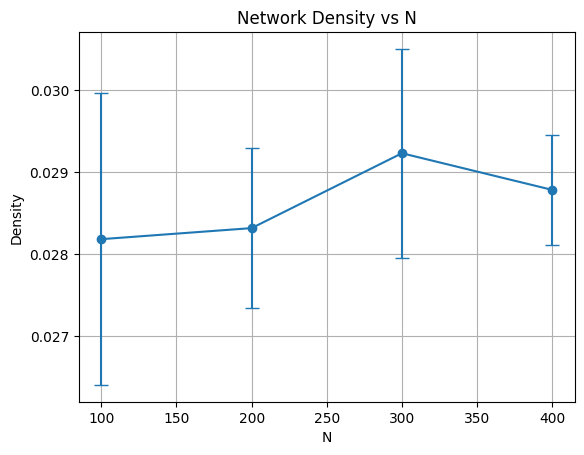

In [83]:


def calculate_density_stats(N, min_d, dim, num_iterations=10):
    densities = []
    for _ in range(num_iterations):
        # G, _ = generate_spatial_network_scaled(N, min_d, dim)
        G, _ = generate_spatial_network(N, min_d, dim)

        densities.append(nx.density(G))
    avg_density = np.mean(densities)
    std_density = np.std(densities)
    return avg_density, std_density

def plot_density_vs_N(N_values, min_d, dim, num_iterations=10):
    avg_densities = []
    std_densities = []

    for N in N_values:
        avg_density, std_density = calculate_density_stats(N, min_d, dim, num_iterations)
        avg_densities.append(avg_density)
        std_densities.append(std_density)

    plt.errorbar(N_values, avg_densities, yerr=std_densities, fmt='-o', capsize=5)
    plt.xlabel('N')
    plt.ylabel('Density')
    plt.title('Network Density vs N')
    plt.grid(True)
    plt.show()

# Parameters
N_values = [100, 200, 300, 400]
min_d = 0.1
dim = 2
num_iterations = 10

plot_density_vs_N(N_values, min_d, dim, num_iterations)
